
# Here we provide a jupyter notebook to reproduce results showed in the article, especially Fig.3. and Fig.S2

In [1]:
# import libraries
from incidence_model import * #custom library, can be found in folder incidence_model.py
import matplotlib.pyplot as pyplot
import numpy as np
import matplotlib.patches as patches
import time
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import matplotlib.ticker as mticker

In [ ]:
#ray for cpu multithreading, to make parallel calculations
import ray
ray.init()

2021-09-29 14:42:56,009	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


### Define incidence threshold value

In [2]:
incidence_value = 1e-1

In [ ]:
# main fucntion which calculates the probabilities for given amplification factor values
# input mu->mutation rate, N->total number of cells produced by the tissue over the lifetime
# s_scheme: the mode of mutations selective advantages -> 
#->{scd,scdd,neutral} ->{symmetric division drivers, symmetrif differentiation drivers, neutral mutations}
# s: strength of mutations 
# for more parameter description check Supplementary material Table.1.
@ray.remote
def drift_bar(mu,N,N0,s_scheme,s,incidence=incidence_value):
    gamma_scan = arange(2,4,1/20.)
    nopt=np.log2(N/N0)
    for n in arange(2,nopt+1):
        
            P_scan = array([Pis(mu,n,s,gamma,[0,N/N0],s_scheme)[-1] for gamma in gamma_scan ] )   # calculate the probabilities for a given schema (etc. scd)
            
            P_min = np.min(P_scan) # obtain minimum probability

            i_min = np.argmin(P_scan) # index value corresponding to the minimum probability

            gamma_min = gamma_scan[i_min]  # obtain the vlaue of the amplification factor where the probability os minimized 

            if P_min < incidence/N0:
                return {"n":n, "gamma":gamma_min, "d":int(math.ceil(1.0/(gamma_min-1.0)/s)), "r0":(gamma_min**(1.0-n))*N/N0/365.}  
    return {"n":-1, "gamma":-1, "d":-1, "r0":-1}

### Define the resolution of heatmaps (dim: RESXRES)

In [3]:
# the original resolution in the article (if you modify it there will be an error if you plot the original files)
RES=200

In [4]:
# define custom colormap
viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([256/256, 256/256, 256/256, 1])
black = np.array([0/256, 0/256, 0/256, 1])
newcolors[:1, :] = white
#cf. https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html


In [ ]:
# helper function to generate heatmap data for both Blood and Colon parametrization
# for different heatmaps such as {mu,s},{N,s},{N,mu}.

def DataGeneratorNs(X1,X2,Y1,Y2,mu,N01,N02):

    time_s = time.time()

    points=[]
    for s in Y1:
        for N in X1:
            points+=[drift_bar.remote(mu,N,N01,"scd",s)]
    points = ray.get(points)

    p_1 = points


    points=[]
    for s in Y2:
        for N in X2:
            points+=[drift_bar.remote(mu,N,N02,"scd",s)]
    points = ray.get(points)

    p_2 = points

    print(time.time()-time_s," seconds elapsed for ", RES,"X",RES)

    points = []
    
    return [p_1,p_2]

def DataGeneratorMuN(X1,X2,Y1,Y2,s,N01,N02):

    time_s = time.time()

    points=[]
    for mu in Y1:
        for N in X1:
            points+=[drift_bar.remote(mu,N,N01,"scd",s)]
    points = ray.get(points)

    p_1 = points


    points=[]
    for mu in Y2:
        for N in X2:
            points+=[drift_bar.remote(mu,N,N02,"scd",s)]
    points = ray.get(points)

    p_2 = points
    

    print(time.time()-time_s," seconds elapsed for ", RES,"X",RES)

    points = []
    
    return [p_1,p_2]

  
def DataGeneratorMus(X1,X2,Y1,Y2,N1,N2,N01,N02):

    time_s = time.time()

    points=[]
    for s in Y1:
        for mu in X1:
            points+=[drift_bar.remote(mu,N1,N01,"scd",s)]
    points = ray.get(points)

    p_1 = points


    points=[]
    for s in Y2:
        for mu in X2:
            points+=[drift_bar.remote(mu,N2,N02,"scd",s)]
    points = ray.get(points)

    p_2 = points

    print(time.time()-time_s," seconds elapsed for ", RES,"X",RES)

    points = []
    
    return [p_1,p_2]


# Reproducing Fig.3 and Fig.S2 plots

# Section 1.
## In this section one can generate the data, and the data can be saved to .txt files,so there is no need to regenerate the data every instances
## See functions below (#load data from txt,HeatMapPlotterFromTXT )
## If you want to generate new data with new parameters, use this section, if you want to just reproduce the plots showed in the article, go below section 2.


In [ ]:
#generate data for N vs s plot

X1, Y1 = 10**np.linspace(8, 18, RES),  np.linspace(0.02,0.3,RES) # input axis for tisse #1
X2, Y2 = 10**np.linspace(12, 22, RES),  np.linspace(0.02,0.3,RES) # input axis for tisse #2

inputData_N_s = DataGeneratorNs(X1,X2,Y1,Y2,1e-5,1e4,1e8)

In [ ]:
# structures the heatmap data into 4 differet slices for {N,s} heatmaps both for Blood and Colon data
# see in Fig.3. or SuppMat Fig.S2, Fig.S3
inputData = inputData_N_s

data_type = ["n","gamma","d","r0"]
dataCollb = [0]*4
dataCollc = [0]*4

bpoints = inputData[0]
cpoints = inputData[1]

d_index = 0
for d in range(4):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bpoints]).reshape(RES,RES)
    else:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bn_points]).reshape(RES,RES)

    d_index+=1

np.savetxt("N_s_b_1"+str(incidence_value)+".txt",dataCollb[0],fmt='%.2e' )
np.savetxt("N_s_b_2"+str(incidence_value)+".txt",dataCollb[1],fmt='%.2e' )
np.savetxt("N_s_b_3"+str(incidence_value)+".txt",dataCollb[2],fmt='%.2e' )
np.savetxt("N_s_b_4"+str(incidence_value)+".txt",dataCollb[3],fmt='%.2e' )


d_index = 0
for d in range(4):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollc[d] = array([round(point[data_type[d_index]],2) for point in cpoints]).reshape(RES,RES)

    d_index+=1    


np.savetxt("N_s_c_1"+str(incidence_value)+".txt",dataCollc[0],fmt='%.2e' )
np.savetxt("N_s_c_2"+str(incidence_value)+".txt",dataCollc[1],fmt='%.2e' )
np.savetxt("N_s_c_3"+str(incidence_value)+".txt",dataCollc[2],fmt='%.2e' )
np.savetxt("N_s_c_4"+str(incidence_value)+".txt",dataCollc[3],fmt='%.2e' )

In [ ]:
# generate data for mu vs s plot

X1, Y1 = 10**np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES)  # input axis for tisse #1
X2, Y2 = 10**np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #2    
N1,N2,N01,N02 = 1e14,1e14,1e4,1e8
inputData_mu_s = DataGeneratorMus(X1,X2,Y1,Y2,N1,N2,N01,N02)

In [ ]:
# structures the heatmap data into 4 differet slices for {mu,s} heatmaps both for Blood and Colon data
# see in Fig.3. or SuppMat Fig.S2, Fig.S3
inputData = inputData_mu_s
data_type = ["n","gamma","d","r0"]
dataCollb = [0]*4
dataCollc = [0]*4

bpoints = inputData[0]
cpoints = inputData[1]

d_index = 0
for d in range(4):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bpoints]).reshape(RES,RES)
    else:

        dataCollb[d] = array([round(point[data_type[d_index]],2) for point in bn_points]).reshape(RES,RES)

    d_index+=1

np.savetxt("mu_s_b_1"+str(incidence_value)+".txt",dataCollb[0],fmt='%.2e' )
np.savetxt("mu_s_b_2"+str(incidence_value)+".txt",dataCollb[1],fmt='%.2e' )
np.savetxt("mu_s_b_3"+str(incidence_value)+".txt",dataCollb[2],fmt='%.2e' )
np.savetxt("mu_s_b_4"+str(incidence_value)+".txt",dataCollb[3],fmt='%.2e' )


d_index = 0
for d in range(4):
    if d_index==4:
        d_index=0

    if d<4:

        dataCollc[d] = array([round(point[data_type[d_index]],2) for point in cpoints]).reshape(RES,RES)

    d_index+=1    

np.savetxt("mu_s_c_1"+str(incidence_value)+".txt",dataCollc[0],fmt='%.2e' )
np.savetxt("mu_s_c_2"+str(incidence_value)+".txt",dataCollc[1],fmt='%.2e' )
np.savetxt("mu_s_c_3"+str(incidence_value)+".txt",dataCollc[2],fmt='%.2e' )
np.savetxt("mu_s_c_4"+str(incidence_value)+".txt",dataCollc[3],fmt='%.2e' )



# Section 2.
## Here you can reproduce the plots showed in the article using the original data.

In [5]:

#load data from txt
# you dont have to regenerate funcitons above as they can be very time consuming even on powerful CPU-s
# original data can be found in ./data folder.

#original (same as in the article) data folder
data_folder = "./data/"

#newly created data folder
#data_folder = "./"

inputData_mu_s_b = [np.loadtxt(data_folder+"mu_s_b_1"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"mu_s_b_2"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"mu_s_b_3"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"mu_s_b_4"+str(incidence_value)+".txt")]

inputData_mu_s_c = [np.loadtxt(data_folder+"mu_s_c_1"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"mu_s_c_2"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"mu_s_c_3"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"mu_s_c_4"+str(incidence_value)+".txt")]



inputData_N_s_b = [np.loadtxt(data_folder+"N_s_b_1"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"N_s_b_2"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"N_s_b_3"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"N_s_b_4"+str(incidence_value)+".txt")]

inputData_N_s_c = [np.loadtxt(data_folder+"N_s_c_1"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"N_s_c_2"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"N_s_c_3"+str(incidence_value)+".txt"),np.loadtxt(data_folder+"N_s_c_4"+str(incidence_value)+".txt")]



In [6]:
# plot data from the TXT files saved and loaded above
#format for power notation

def HeatMapPlotterFromTXT(X1,X2,Y1,Y2,N01,N02,inputData,plot_type,Xlabel,Ylabel,alphaval,im_w,im_h,tissue_type,hl_x_min,hl_x_max,hl_y_min,hl_y_max): # alpha value of heatmap highlights, image width and height, type of tissue: blood or colon
    

    
    data_type = ["n","gamma","d","r0"]
    c_labels =["$n_\mathrm{drift}$","$\gamma_\mathrm{drift}$","$d_\mathrm{drift}$","$r_0^\mathrm{drift}$"] 
    vminR = [0.99,1.99,0.99,1e-2]
    vmaxR = [35,4.0,10.0,1e3]
 

    if tissue_type=="blood":
        X = X1
        Y = Y1
        N0 = N01

    else:
        X = X2
        Y = Y2
        N0 = N02

    dataColl = inputData


    fig, axes = plt.subplots(figsize=(im_w,im_h), nrows=1, ncols=4);

    m_index=0
    #fig.suptitle(tissue_type+" "+"scd (top) and neutral (bottom)") 

    if tissue_type=="blood":
        fig.text(0.488,0.82,"blood \n \n",fontsize = 35)
    else:
        fig.text(0.48,0.82,"colon \n \n",fontsize = 35)
    plt.subplots_adjust(wspace=0.1, hspace=0.5) 
   
    for m, ax in zip(range(0,4), axes.flat):

        y, x = np.meshgrid(Y, X)
        z = dataColl[m]
        z=z.T

        if m_index==4:
            m_index=0

        if m==3 or m==7:
            cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True) 
        else:
            cmesh = ax.pcolormesh(x, y, z,cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True) 
        cb=fig.colorbar(cmesh,ax=ax)
        cb.set_label(label=c_labels[m_index],fontsize=labels_size,rotation = 90)
        
        
        if Xlabel == "$N/N_0$":
            X_new = np.linspace(X[0],X[-1],6)
            X_relable = ["$10^{"+str(int(X[0]-2- int(math.log(N0)/math.log(10))) )+"}$"]
            for i in range(len(X_new)):
                power = int(X_new[i]) - int(math.log(N0)/math.log(10)) 
                X_relable.append("$10^{"+str(power )+"}$")
        
            #ax.set_xtics([0,1,2,3,4,5,6,7,8,9])
            ax.set_xticklabels(X_relable)

            
        else:    
            ax.set_xscale('log')
        if Ylabel !="$s$":
            ax.set_yscale('log')
        ax.tick_params(direction='out', length=4, width=2, colors='black',grid_color='black', grid_alpha=1.0,labelsize=tick_ls);     # tick settings

        cb.ax.tick_params(labelsize=cb_ts)
        
        
        ax.set_xlabel(Xlabel,fontsize=labels_size)
        
        # set the highlighted box and set alpha by user input (see description in a cell below)
                
        #print(X,Y)
        # here you can experiment with plotting grey highlighting areas to the plots
        '''
        if hl_x_min>amin(X): # draw rectangle on left side from highlight (if possible)
            ax.add_patch(Rectangle((amin(X), amin(Y)), hl_x_min-amin(X), amax(Y)-amin(Y), fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));
        
        if hl_x_max<amax(X): # draw rectangle on right side from highlight (if possible)
            ax.add_patch(Rectangle((hl_x_max, amin(Y)), amax(X)-hl_x_max, amax(Y)-amin(Y), fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));
        
        if hl_y_max<amax(Y): # draw rectangle above highlight (if possible)
            ax.add_patch(Rectangle((hl_x_min,hl_y_max), hl_x_max-hl_x_min, amax(Y)-hl_y_max, fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));

        if hl_y_min>amin(Y): # draw rectangle below highlight (if possible)
            ax.add_patch(Rectangle((hl_x_min,amin(Y)), hl_x_max-hl_x_min, hl_y_min-amin(Y), fill=True, color = 'gray', edgecolor=None, lw=0, alpha=alphaval,zorder = 5));

        #draw black dashed highlight zone
        ax.add_patch(Rectangle((hl_x_min, hl_y_min), hl_x_max-hl_x_min, hl_y_max-hl_y_min, fill=False, edgecolor='black', linestyle = '--',  lw=5,alpha=1.0,zorder = 10));
        ''' 
        m_index +=1


    #plt.tight_layout();

    plt.show()
    if tissue_type=="blood":
        fig.savefig("Fig_S2_"+plot_type+"_blood_gamma"+str(incidence_value)+".pdf")
    else:
        fig.savefig(plot_type+"_colon_gamma"+str(incidence_value)+".pdf")

## Define plot parameters and plot from TXT files

<ipython-input-6-b7df7658b35e>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_relable)
<ipython-input-6-b7df7658b35e>:48: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


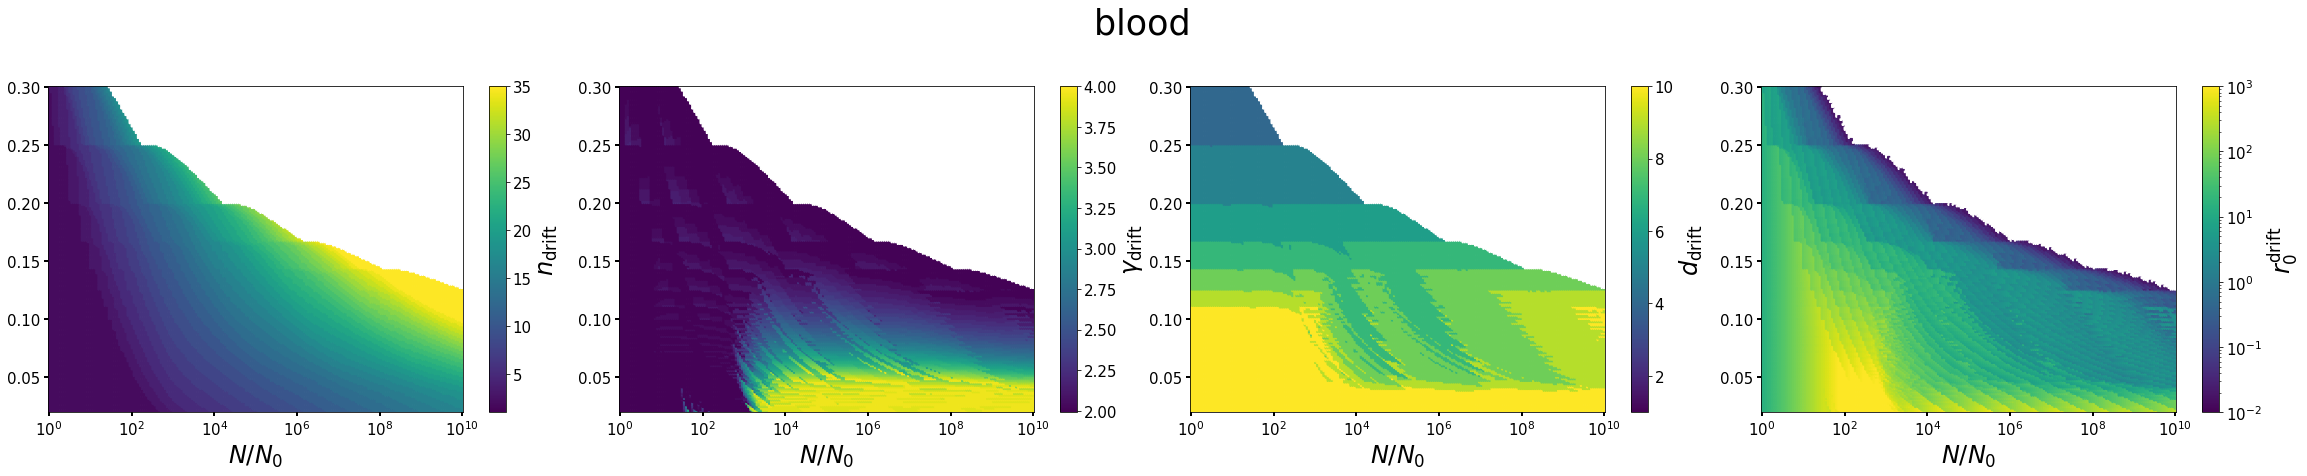

<ipython-input-6-b7df7658b35e>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(X_relable)
<ipython-input-6-b7df7658b35e>:48: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


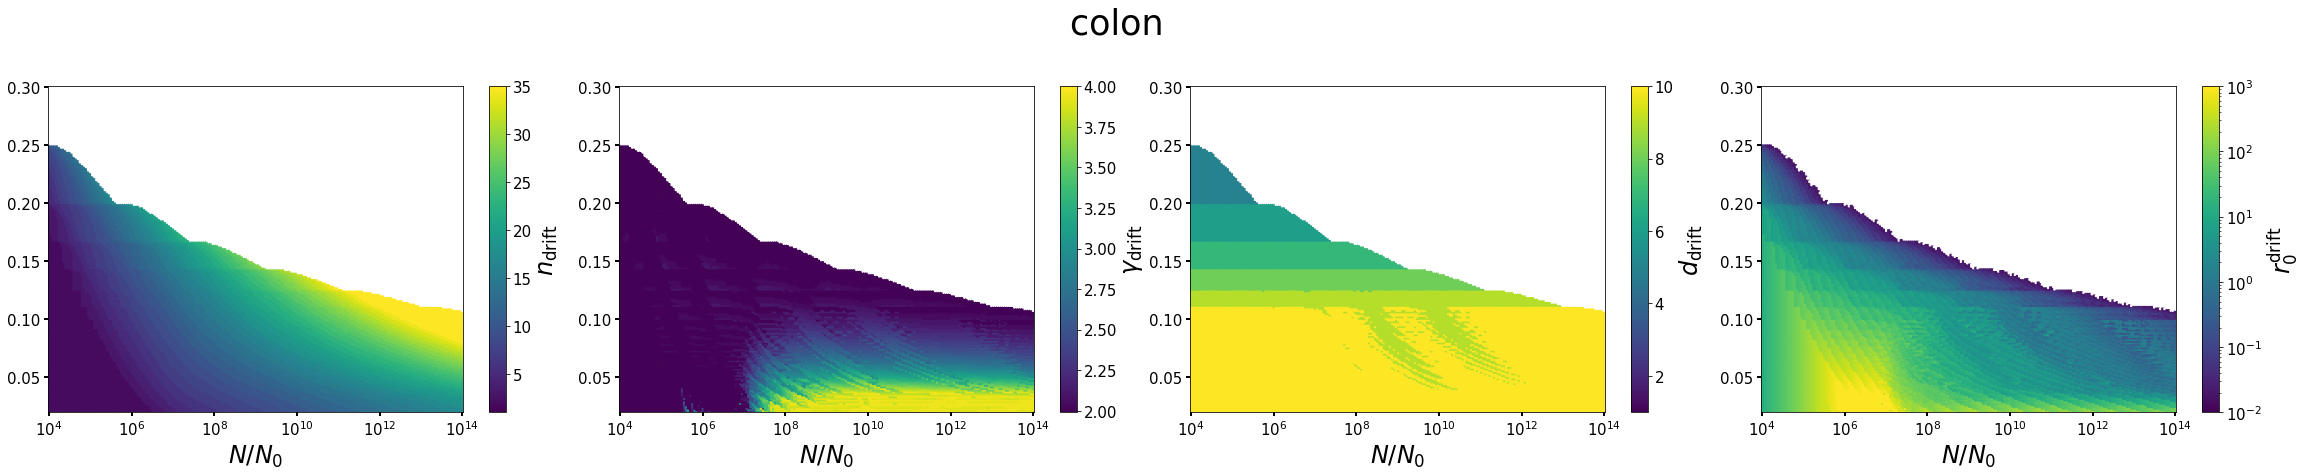

In [7]:
#PLOT FROM DATA

#hl_x_min,hl_x_max,hl_y_min,hl_y_max: 
#(hl_x_min,hl_ymin) : lower left corner of bounding box 
#(hl_x_max,hl_ymax) : upper right corner of bounding box
#       x
#(0,0)-------->
#   |                        (hl_x_max,hl_y_max)
#   |   +---------------------------+
# y |   :                           :
#   |   :                           :
#   |   :                           :
#   |   :                           :
#   V   :                           :
#       :                           :
#       +---------------------------+
# (hl_x_min,hl_y_min)
#                             
#            



alphaval = 0.6 # highlighting ares alpha value, have to uncomment in HeatMapPlotterFromTXT function

labels_size = 24 # X,Y,Z labels size


cb_ts = 15 # colorbar tick number font size

tick_ls = 15

title_s = 60 # size of title
im_w,im_h = 40,6  # image width and height
cb_scale = 4.8   # scale of colorbar font size
x_rot,y_rot = 90,0  # rotation of x and y tick labels

# generate N vs s plots
N01,N02 = 1e4,1e8
Xlabel = "$N/N_0$"
Ylabel = "$s$"

X1, Y1 = np.linspace(4, 14, RES),   np.linspace(0.02,0.3,RES) # input axis for tisse #1
X2, Y2 = np.linspace(12, 22, RES),  np.linspace(0.02,0.3,RES) # input axis for tisse #2

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 10,10,0.0,0.3
HeatMapPlotterFromTXT(X1,X2,Y1,Y2,N01,N02,inputData_N_s_b,"N_s",Xlabel,Ylabel,0.7,im_w,im_h,"blood",hl_x_min,hl_x_max,hl_y_min,hl_y_max);

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 10,10,0.0,0.3
HeatMapPlotterFromTXT(X1,X2,Y1,Y2,N01,N02,inputData_N_s_c,"N_s",Xlabel,Ylabel,0.7,im_w,im_h,"colon",hl_x_min,hl_x_max,hl_y_min,hl_y_max); 


<ipython-input-6-b7df7658b35e>:48: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


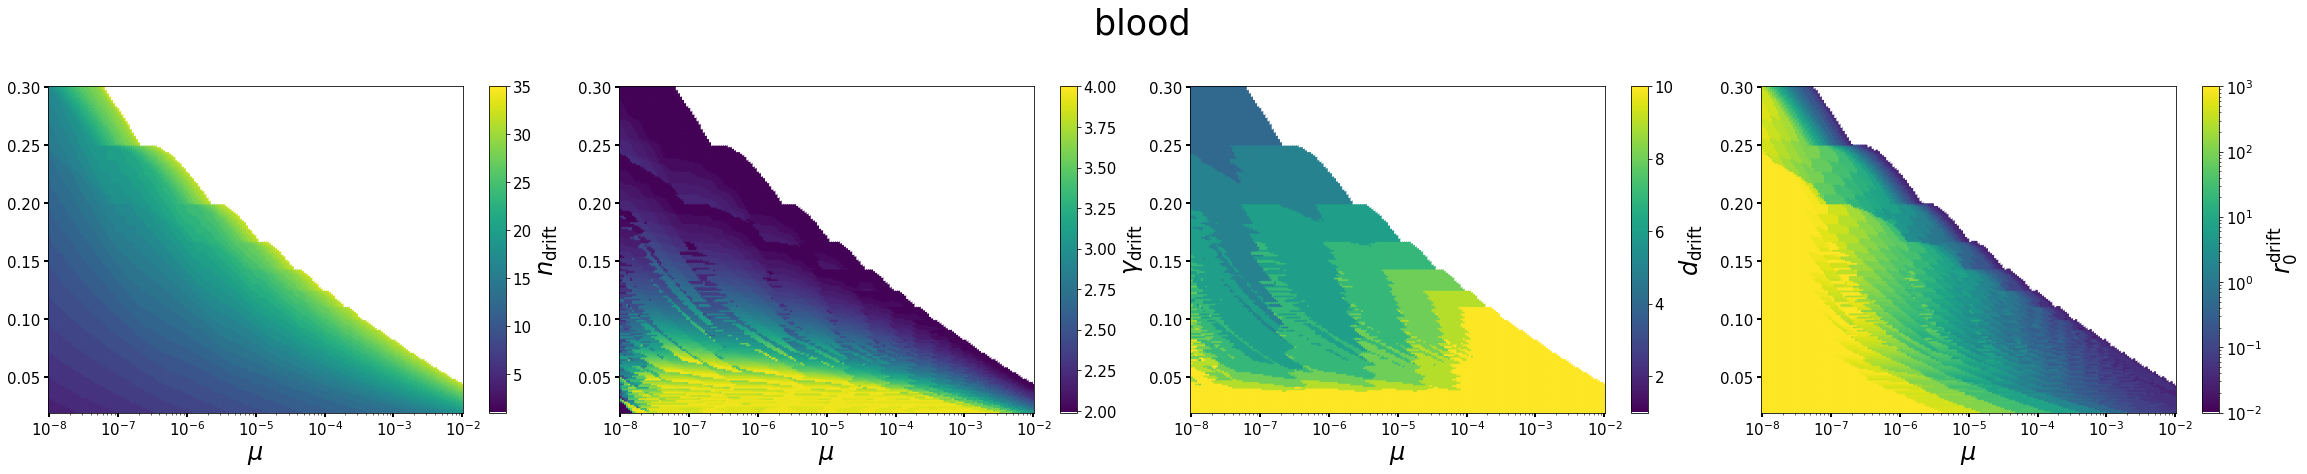

<ipython-input-6-b7df7658b35e>:48: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmesh = ax.pcolormesh(x, y, z,norm=LogNorm(),cmap=ListedColormap(newcolors),vmin=vminR[m_index],vmax=vmaxR[m_index],antialiased=True, shading="nearest" , snap=True,edgecolors="face", rasterized=True)


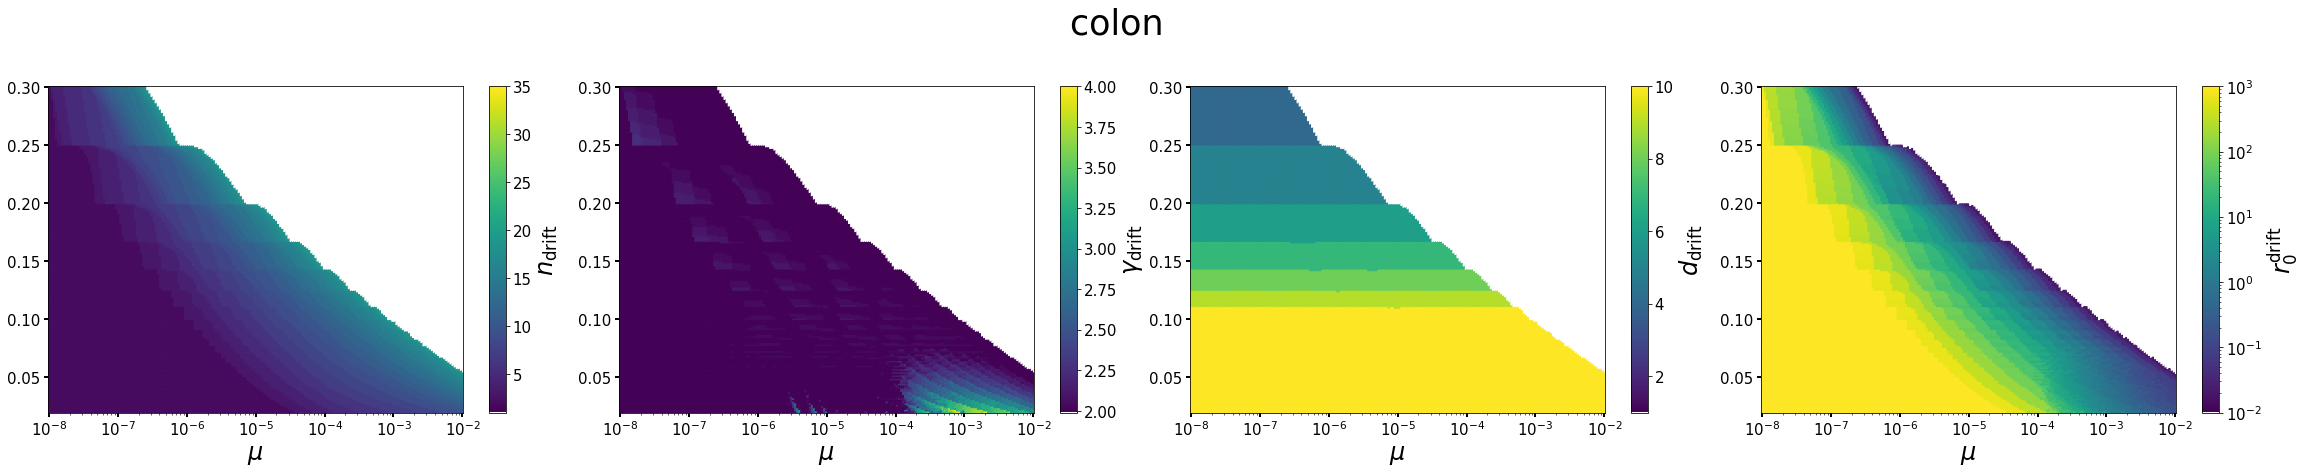

In [8]:

#generate mu vs s plots

X1, Y1 = 10**np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES)  # input axis for tisse #1
X2, Y2 = 10**np.linspace(-2, -8, RES), np.linspace(0.02,0.3,RES) # input axis for tisse #2   

Xlabel = "$\mu$"
Ylabel = "$s$"

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 1e-6,1e-4,0.1,0.3
HeatMapPlotterFromTXT(X1,X2,Y1,Y2,N01,N02,inputData_mu_s_b,"mu_s",Xlabel,Ylabel,0.7,im_w,im_h,"blood",hl_x_min,hl_x_max,hl_y_min,hl_y_max);

hl_x_min,hl_x_max,hl_y_min,hl_y_max = 1e-6,1e-4,0.1,0.3

HeatMapPlotterFromTXT(X1,X2,Y1,Y2,N01,N02,inputData_mu_s_c,"mu_s",Xlabel,Ylabel,0.7,im_w,im_h,"colon",hl_x_min,hl_x_max,hl_y_min,hl_y_max); 

